In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats
import tensorflow as tf
import math
import random

fps=120
threshold=0.75
moving_avg_len=10
filter_value = 20

%matplotlib inline
plt.style.use('ggplot')

file name is circle_sskim_changed.csv num is 0
file datat is  [[-0.2450045 -0.4015781  0.4612551]
 [-0.2451781 -0.3991136  0.4627702]
 [-0.2448999 -0.3973651  0.4639525]
 ...
 [-0.2188472 -0.4788571  0.3984939]
 [-0.2170342 -0.4778079  0.4001951]
 [-0.2152738 -0.4769836  0.4017951]]
size of  55961
size of divide  1399
records is  [-0.2450045 -0.4015781  0.4612551]
start 0
end 1080
step is  1
length of end-start 1080
start 1200
end 2880
step is  2
length of end-start 1680
start 3000
end 10440
step is  3
length of end-start 7440
start 10560
end 13560
step is  4
length of end-start 3000
start 13680
end 15240
step is  5
length of end-start 1560
start 15360
end 16920
step is  6
length of end-start 1560
start 17040
end 18600
step is  7
length of end-start 1560
start 18720
end 20280
step is  8
length of end-start 1560
start 20400
end 25200
step is  9
length of end-start 4800
start 25320
end 32760
step is  10
length of end-start 7440
start 32880
end 34200
step is  11
length of end-start 1320
s

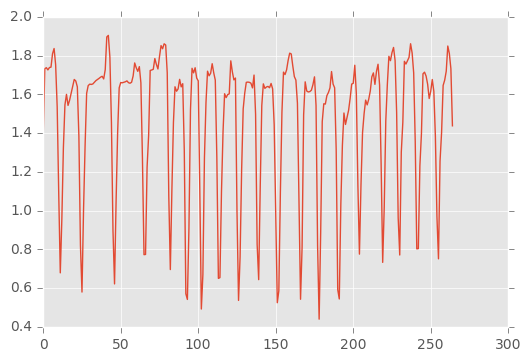

In [4]:
def readFileData(file):
    column_names = ['wmx1', 'wmy1', 'wmz1']

    data = pd.read_csv(file, skiprows = 1 , names = column_names)
 
    wx = data["wmx1"]
    wy = data["wmy1"]
    wz = data["wmz1"]

    records=movingavg(wx,wy,wz)

    return np.dstack([wx,wy,wz])[0]

def readData(directory):
    records = []
    labels = np.empty(0)
    label = "circle"
    allFiles = glob.glob("*.csv")
    for i,file in enumerate(allFiles):
        fileName = os.path.basename(file)
        print("file name is", fileName,"num is",i)
        (name, ext) = os.path.splitext(fileName)
        if (True):
            fileData = readFileData(file)
            print("file datat is ",fileData)
            records.append(fileData)
            labels = np.append(labels, label)

    return (records, labels)

def movingavg(x,y,z):
    x_avg = np.zeros(moving_avg_len)/moving_avg_len
    y_avg = np.zeros(moving_avg_len)/moving_avg_len
    z_avg = np.zeros(moving_avg_len)/moving_avg_len
    x_avg = np.convolve(x,x_avg,'same')
    y_avg = np.convolve(y,y_avg,'same')
    z_avg = np.convolve(z,z_avg,'same')
    
    return [x_avg,y_avg,z_avg]

def splitData(records):##sungshil
    print("records is ",records[0][0])
    term=fps//4
    record_sum=[]
    record=[]
    record_all=[]
    ct=0
    sum_now=0.0
    sum_pre=0.0
    start=0
    end=0
    
    for i in range((len(records[0])//(term))-100):
        sum=0.0
        record_x=np.empty(shape=[1],dtype=float)
        record_y=np.empty(shape=[1],dtype=float)
        record_z=np.empty(shape=[1],dtype=float)
        for j in range(fps):
            record_x=np.append(record_x,records[0][term*i+j][0])
            record_y=np.append(record_y,records[0][term*i+j][1])
            record_z=np.append(record_z,records[0][term*i+j][2])
        for k in range(fps-2):
            sum=sum+(record_x[k]-record_x[k+1])**2+(record_y[k]-record_y[k+1])**2+(record_z[k]-record_z[k+1])**2
            
        sum_pre=sum_now
        sum_now=sum
        record_sum.append(sum)
        if (sum_pre<threshold and sum_now>threshold):
            
            ct=ct+1
            start=120*i
            print("start",start)
        if (sum_pre>threshold and sum_now<threshold):
            end=120*i  
            print("end",end)
            print("step is " ,ct)
            print("length of end-start",(end-start))
            s=[]
            for k in range(end-start):
                t=(records[0][term*i+j+k])
                #print("t is",t)
                s.append(t)
                #print("s is ",s)
            record_all.append(s)
       
    
    
    print("number of patterm : ",ct)
    print("average is",np.average(record_sum))
    print("number of term",len(record_sum))
    plt.plot(record_sum[1500:2500])
    
    return record_all

def getRecordsMaxLength(records):
    maxLen = 0
    for record in records:
        if (len(record) > maxLen):
            maxLen = len(record)
        
    return maxLen

def extendRecordsLen(records, length):
    ret = np.empty((0, length, 3))
    for index in range(len(records)):
        record = records[index]
        if (len(record) < length):
            record = np.pad(record, ((0, length - len(record)), (0,0)), mode='constant', constant_values=0)
            

        ret = np.append(ret, [record], axis=0)
    print("1-2")

    return ret

def weight_variable(shape):#가중치 생성
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):#편향 생성
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):#각 채널마다 활성곱 수행후 ReLu활성화 함수로 pass
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):#생성된 convolution층에 pooling 적용
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

(records,label)=readData("dr")
print("size of ",len(records[0]))
print("size of divide ",len(records[0])//40)
#records=filter_data(records)
records=splitData(records)
max_len=getRecordsMaxLength(records)
records=extendRecordsLen(records, max_len)




In [11]:
print(len(records[0]))

#reshaped_records = records.reshape(len(records), 1,90, 3) #recoed를 1차원으로 reshape


11400
